## Transfer Learning

In this problem, we will train a convolutional neural network for image classification using transfer learning.
Transfer learning involves training a base network from scratch on a very large dataset (e.g., Imagenet1K
with 1.2M images and 1K categories) and then using this base network either as a feature extractor or as an
initialization network for a target task. Thus two major transfer learning scenarios are as follows:

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **Base model as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


Following the tutorial at : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

### Load Data


**We will use torchvision and torch.utils.data packages for loading the
data.**


**Dataset used : FGVCAircraft**

In [ ]:
from torchvision.datasets import FGVCAircraft
from torch.utils.data import DataLoader

# Define transformations for data preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the Aircraft dataset
train_dataset = FGVCAircraft(root='./data', split='train', transform=data_transforms['train'], download=True)
val_dataset = FGVCAircraft(root='./data', split='test', transform=data_transforms['val'], download=True)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# Calculate dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Retrieve class names
class_names = train_dataset.classes

print("Dataset sizes:", dataset_sizes)
print("Class names:", class_names)


Dataset sizes: {'train': 3334, 'val': 3333}
Class names: ['707-320', '727-200', '737-200', '737-300', '737-400', '737-500', '737-600', '737-700', '737-800', '737-900', '747-100', '747-200', '747-300', '747-400', '757-200', '757-300', '767-200', '767-300', '767-400', '777-200', '777-300', 'A300B4', 'A310', 'A318', 'A319', 'A320', 'A321', 'A330-200', 'A330-300', 'A340-200', 'A340-300', 'A340-500', 'A340-600', 'A380', 'ATR-42', 'ATR-72', 'An-12', 'BAE 146-200', 'BAE 146-300', 'BAE-125', 'Beechcraft 1900', 'Boeing 717', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700', 'CRJ-900', 'Cessna 172', 'Cessna 208', 'Cessna 525', 'Cessna 560', 'Challenger 600', 'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9-30', 'DH-82', 'DHC-1', 'DHC-6', 'DHC-8-100', 'DHC-8-300', 'DR-400', 'Dornier 328', 'E-170', 'E-190', 'E-195', 'EMB-120', 'ERJ 135', 'ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16A/B', 'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50', 'Fokker 70', 'Global Express', 'Gulfstream IV', 'G

In [ ]:
dataloaders = {'train': train_loader,
            'val': val_loader}

### Visualize a few images

Let\'s visualize a few training images so as to understand the data
augmentations.


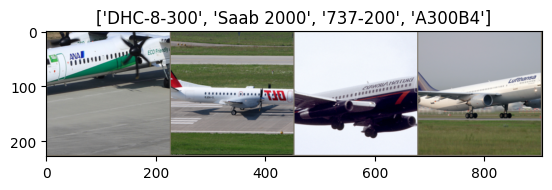

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### a) *Finetuning*
You will first load a pre-trained model (ResNet50) and change the final fully connected layer output to the number of classes in the target dataset.

In [ ]:
# Check if a GPU is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
model_ft = models.resnet50(weights='IMAGENET1K_V1')

# Get the number of input features for the final fully connected layer
num_ftrs = model_ft.fc.in_features

# Modify the final layer to match the number of classes in the Aircraft dataset
num_classes = len(class_names)  # Use the length of class_names from the dataset
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the device
model_ft = model_ft.to(device)

print("Number of classes: ", num_classes)

Number of classes:  100


### b) Initial Finetuning
First finetune by setting the same value of hyperparameters (learning rate=0.001, momentum=0.9) for all the layers. Keep batch size of 64 and train for 150-200 epochs or until model converges well. You will use a multi-step learning rate schedule and decay by a factor of 0.1 (γ = 0.1 in the below template cell). You can choose steps at which you want to decay the learning rate but do 3 drops during the training. So the first drop will bring down the learning rate to 0.0001, second to 0.00001, third to 0.000001. For example, if training for 150 epochs, first drop can happen at epoch 40, second at epoch 80 and third at epoch 120.

**We are going to be using validation data as our test set since the test data is not annotated.**

In [ ]:
# Re-loading the Aircraft dataset with batch-size 64
train_dataset = FGVCAircraft(root='./data', split='train', transform=data_transforms['train'], download=True)
val_dataset = FGVCAircraft(root='./data', split='test', transform=data_transforms['val'], download=True)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Calculate dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Retrieve class names
class_names = train_dataset.classes

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_0_001 = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.001 at each of the milestones
exp_lr_scheduler_0_001 = lr_scheduler.MultiStepLR(optimizer_ft_0_001, milestones=[40, 80, 120], gamma=0.1)

# Optionally, print the model architecture
print(model_ft)


#### *Train and evaluate*

In [ ]:
print("Training the model with LR: 0.001...")
model_ft_0_001 = train_model(model_ft, criterion, optimizer_ft_0_001, exp_lr_scheduler_0_001,
                             num_epochs=150)

In [ ]:
best_model_params_path = os.path.join('./data', 'best_model_params_0_001.pt')
torch.save(model_ft_0_001.state_dict(), best_model_params_path)

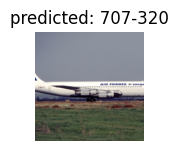

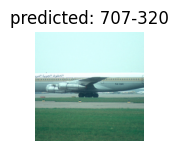

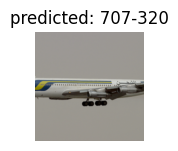

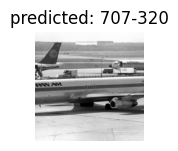

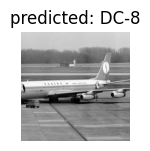

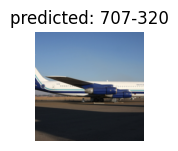

In [ ]:
visualize_model(model_ft_0_001)

### c) Trials with different learning rates:

Next keeping all the hyperparameters same as before (including multi-step learning rate schedule), change the learning rate to 0.01 and 0.1 uniformly for all the layers. This means keep all the layers at same learning rate. So you will be doing two experiments, one keeping learning rate of all layers at 0.01 and one with 0.1. Again finetune the model, using the same mutli-step learning rate schedule as in Part (b), and report the final accuracy. How does the accuracy with the three learning rates compare? Which learning rate gives you the best accuracy on the target dataset?

In [ ]:
# Training with 0.01 LR
optimizer_ft_0_01 = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler_0_01 = lr_scheduler.MultiStepLR(optimizer_ft_0_01, milestones=[40, 80, 120], gamma=0.1)
model_ft_0_01 = train_model(model_ft, criterion, optimizer_ft_0_01, exp_lr_scheduler_0_01,
                            num_epochs=150)

In [ ]:
best_model_params_path = os.path.join('./data', 'best_model_params_0_01.pt')
torch.save(model_ft_0_01.state_dict(), best_model_params_path)

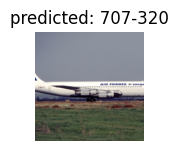

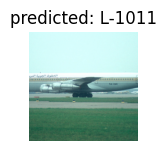

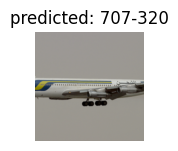

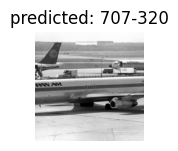

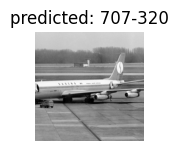

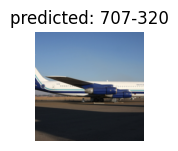

In [ ]:
visualize_model(model_ft_0_01)

In [ ]:
# Training with 0.1 LR
optimizer_ft_0_1 = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler_0_1 = lr_scheduler.MultiStepLR(optimizer_ft_0_1, milestones=[40, 80, 120], gamma=0.1)
model_ft_0_1 = train_model(model_ft, criterion, optimizer_ft_0_1, exp_lr_scheduler_0_1,
                           num_epochs=150)

In [ ]:
best_model_params_path = os.path.join('./data', 'best_model_params_0_1.pt')
torch.save(model_ft_0_1.state_dict(), best_model_params_path)

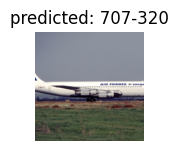

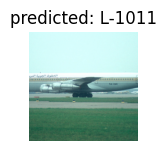

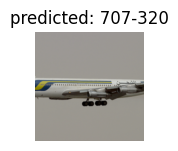

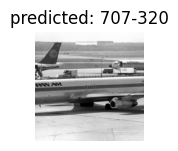

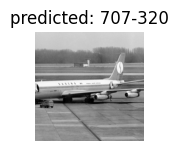

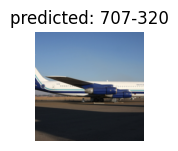

In [ ]:
visualize_model(model_ft_0_1)

This was trained for 150 epochs due to computational restrictions.

| Model Name | Learning Rate | Validation Accuracy | Train Accuracy|
|------------|---------------|----------|----------------|
| model_ft_0_001  | 0.001         | 0.804980     |0.9244
| model_ft_0_01    | 0.01        | 0.665167      |0.8224
| model_ft_0_1    | 0.1          | 0.560756      |0.7109

For our target dataset, model with LR 0.001 performed the best with accuracy 0.804980
A lower learning rate generally allows for slower incremental learning and avoids overfitting.
Given the number of epochs, it got enough time to slowly converge at the optimum point.
We can see in other cases, there is a bigger gap between validation and training accuracy which is also hinting at overfitting.
Using a higher learning rate, the model can oscillate around the optimal point but never reach the optimal point of convergence.

For 0.001 learning rate, the decay might have led to reach to the gradual optima also better due to better loss landscape traversal.

## Part 2

## *Base model* as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [ ]:
# Reinitializing the model with Resnet50 by freezing all layers except the final layer.
model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    # Parameters of newly constructed modules have requires_grad=True by default.
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

**When using a pretrained model as feature extractor, all the layers of the network are frozen except the final layer. Thus except the last layer, none of the inner layers’ gradients are updated during backward pass with the target dataset. Since gradients do not need to be computed for most of the network, this is faster than finetuning.**

### (a) Now train only the last layer for 0.1, 0.01, and 0.001 while keeping all the other hyperparameters and settings same as earlier for finetuning. Which learning rate gives you the best accuracy on the target dataset?

In [ ]:
# Observe that only parameters of final layer are being optimized as opposed to before.

# Starting with LR: 0.001.
optimizer_conv_0_001 = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_0_001 = lr_scheduler.MultiStepLR(optimizer_conv_0_001, milestones=[40, 80, 120], gamma=0.1)

In [ ]:
model_conv_0_001 = train_model(model_conv,
                               criterion,
                               optimizer_conv_0_001,
                               exp_lr_scheduler_0_001,
                               num_epochs=150)

In [ ]:
best_model_params_path = os.path.join('./data', 'best_model_params_conv_0_001.pt')
torch.save(model_conv_0_001.state_dict(), best_model_params_path)

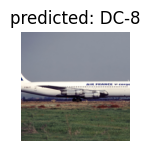

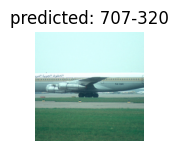

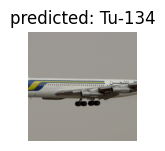

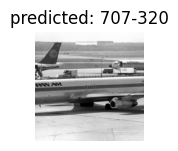

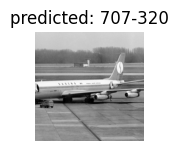

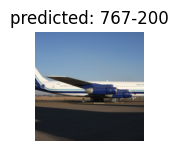

In [ ]:
visualize_model(model_conv_0_001)

In [ ]:
# Starting with LR: 0.01.
optimizer_conv_0_01 = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler_0_01 = lr_scheduler.MultiStepLR(optimizer_conv_0_01, milestones=[40, 80, 120], gamma=0.1)

In [ ]:
model_conv_0_01 = train_model(model_conv,
                              criterion,
                              optimizer_conv_0_01,
                              exp_lr_scheduler_0_01,
                              num_epochs=150)

In [ ]:
best_model_params_path = os.path.join('./data', 'best_model_params_conv_0_01.pt')
torch.save(model_conv_0_01.state_dict(), best_model_params_path)

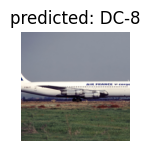

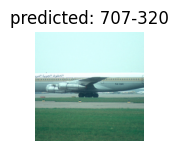

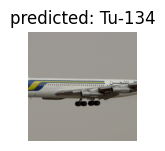

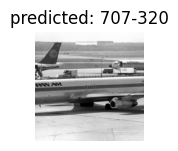

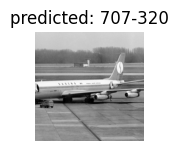

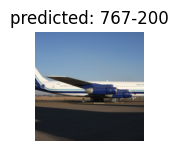

In [ ]:
visualize_model(model_conv_0_01)

In [ ]:
# Starting with LR: 0.1.
optimizer_conv_0_1 = optim.SGD(model_conv.fc.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler_0_1 = lr_scheduler.MultiStepLR(optimizer_conv_0_1, milestones=[40, 80, 120], gamma=0.1)

In [ ]:
model_conv_0_1 = train_model(model_conv,
                              criterion,
                              optimizer_conv_0_1,
                              exp_lr_scheduler_0_1,
                              num_epochs=150)

In [ ]:
best_model_params_path = os.path.join('./data', 'best_model_params_conv_0_1.pt')
torch.save(model_conv_0_1.state_dict(), best_model_params_path)

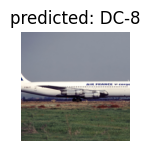

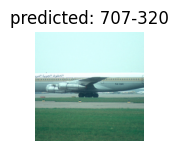

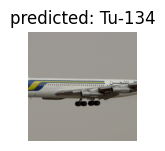

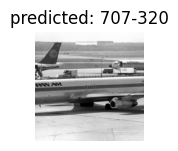

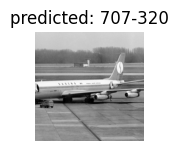

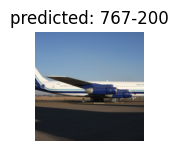

In [ ]:
visualize_model(model_conv_0_1)

#### (b) For your target dataset find the best final accuracy (across all the learning rates) from the two transfer learning approaches. Which approach and learning rate is the winner? Provide a plausible explanation to support your observation.


In both the cases, it was trained for 150 epochs due to computational restrictions.

**When the entire network was fintuned, these are the results:**

| Model Name | Learning Rate | Validation Accuracy | Train Accuracy(last epoch)|
|------------|---------------|----------|----------------|
| model_ft_0_001  | 0.001         | 0.804980     |0.9244
| model_ft_0_01    | 0.01        | 0.665167      |0.8224
| model_ft_0_1    | 0.1          | 0.560756      |0.7109

For our target dataset, in this method, model with LR 0.001 performed the best with accuracy 0.804980.

**When the only the final layer was finetuned keeping all other layers frozen, these are the results:**

| Model Name | Learning Rate | Validation Accuracy | Train Accuracy(last epoch)|
|------------|---------------|----------|----------------|
| model_conv_0_001  | 0.001         | 0.354035     |0.4130
| model_conv_0_01    | 0.01        | 0.374737      |0.3588
| model_conv_0_1    | 0.1          | 0.366637      |0.4952

For our target dataset, in this method, the model with LR 0.01 performed the best with accuracy 0.374737

The best overall validtion accuracy, **0.804980**, was achieved by fine-tuning the entire network with a learning rate of **0.001**.

- Entire Network Fine-Tuning: Allowed all layers to adapt to target dataset, unlike fine-tuning only the final layer, which limited the model's learning capacity.
- Learning Rate: 0.001 provided a balance of stability and effective learning, avoiding the instability seen with higher rates. The multi step decay also helped in this case to go over a larger search space. This helped to go slower closer to the optima and learn better since all other parameters were fixed.
- Given the 150-epoch limit, fine-tuning the entire network enabled better convergence within this constraint. This approach and learning rate gave the highest accuracy for our target dataset.

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [ ]:
# Trying out some predictions

# 1573339 CRJ-700

# This is the real data for the image

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

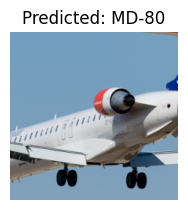

In [ ]:
visualize_model_predictions(
    model_conv_0_001,
    img_path='data/fgvc-aircraft-2013b/data/images/1573339.jpg'
)

plt.ioff()
plt.show()

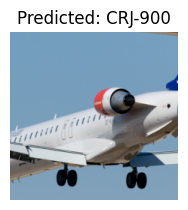

In [ ]:
visualize_model_predictions(
    model_ft_0_01,
    img_path='data/fgvc-aircraft-2013b/data/images/1573339.jpg'
)

plt.ioff()
plt.show()

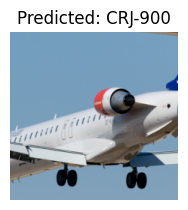

In [ ]:
visualize_model_predictions(
    model_ft_0_1,
    img_path='data/fgvc-aircraft-2013b/data/images/1573339.jpg'
)

plt.ioff()
plt.show()

As we can see the fully finetuned models perform way better in our conditions.

### Further Learning

If you would like to learn more about the applications of transfer
learning, checkout our [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).
